[Python tutorial](https://deltares.github.io/hydromt_sfincs/latest/_examples/build_from_py.html) <br>

    !hydromt --help
    !hydromt build sfincs ./test_sfincs "{'bbox': [91.35453005, 22.46667364, 91.64199094, 22.73206138]}"
    
#### Requirements
1. Pre-processed GIS raster data: must all be on exact same grid, with meta data including a CRS which uses metres, e.q., UTM.
2. Manuallly add forcing data

In [5]:
from os.path import join
from ast import literal_eval
from shapely.geometry import shape, box

import hydromt
from hydromt_sfincs import SfincsModel, utils
import geopandas as gpd
import pandas as pd
import xarray as xr

In [6]:
SfincsModel._MAPS

{'elevtn': 'dep',
 'mask': 'msk',
 'curve_number': 'scs',
 'manning': 'manning',
 'infiltration': 'qinf'}

In [7]:
SfincsModel._GEOMS

{'gauges': 'obs', 'weirs': 'weir', 'thin_dams': 'thd'}

In [8]:
SfincsModel._FORCING

{'waterlevel': ('bzs', 'bnd'),
 'discharge': ('dis', 'src'),
 'precip': ('precip', None),
 'precip2D': ('netampr', None)}

In [9]:
# load general storm/aoi data
storm = "roanu"
region = "chittagong"
subregion = 0
stagger = 0
gridsize = 500
recalculate = False
mask = False

# define directories
wd = join("..", "data", "indata_new")
indir = join(wd, f"{storm}_{region}")
startdate, enddate = [*pd.read_csv(join(wd, "event_dates.csv"),
                                   index_col="storm").loc[storm]]

# extract storm year
dates_df = pd.read_csv(join(wd, "event_dates.csv"))
year = dates_df[dates_df['storm']==storm]['enddate'].reset_index(drop=True)
year = int(year[0][:4])

### Set up elevation data
Currently rasterizing is losing the coordinates, fix this function so that it preserves coordinates.

Saved GeoTIFF to ../data/indata_new/sfincs_data/dep.tif.



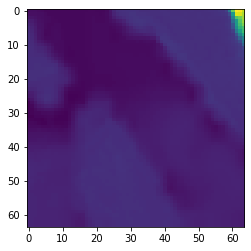

In [17]:
from hybrid_utils import *
import matplotlib.pyplot as plt

feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}_{stagger}.shp'))
im = gdf_to_tiff(feature_gdf, join(wd, "sfincs_data", "dep.tif"), crs_epsg=4326)
plt.imshow(im)

In [22]:
!ls ../data/indata_new/sfincs_data/

# read all data to a Dataset
# note that the names are taken from the file basenames
da_dep = hydromt.open_raster(join(wd, "sfincs_data", "dep.tif"))
da_dep

<xarray.DataArray (y: 64, x: 64)>
dask.array<getitem, shape=(64, 64), dtype=float32, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 59.5 60.5 61.5 62.5 63.5
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 59.5 60.5 61.5 62.5 63.5
    spatial_ref  int64 1
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan

## Set up SFINCS model

In [23]:
mod = SfincsModel(root="sfincs_from_py", mode="w")
# Note this is still an empty model with no maps
len(mod.staticmaps) == 0

True

In [24]:
mod.set_staticmaps(da_dep, name="dep")
mod.staticmaps

<xarray.Dataset>
Dimensions:      (y: 64, x: 64)
Coordinates:
  * y            (y) float64 63.5 62.5 61.5 60.5 59.5 ... 4.5 3.5 2.5 1.5 0.5
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 59.5 60.5 61.5 62.5 63.5
    spatial_ref  int64 1
Data variables:
    dep          (y, x) float32 dask.array<chunksize=(64, 64), meta=np.ndarray>

In [25]:
mod.read_config()  ## laods default config if no sfincs.inp is found in model root
mod.update_spatial_attrs()  # sets mmax, nmax, dx, dy, x0, y0 & epsg based on staticmaps
mod.config  # inspect config

{'mmax': 64,
 'nmax': 64,
 'dx': 1.0,
 'dy': 1.0,
 'x0': 0.0,
 'y0': 0.0,
 'rotation': 0,
 'epsg': 4326,
 'inputformat': 'bin',
 'outputformat': 'net',
 'tref': '20000101 000000',
 'tstart': '20000101 000000',
 'tstop': '20000102 000000',
 'dtout': 3600,
 'dthisout': 600,
 'dtmaxout': 86400,
 'advection': 0,
 'alpha': 0.75,
 'huthresh': 0.05,
 'theta': 0.9,
 'min_lev_hmax': -1,
 'zsini': 0,
 'qinf': 0,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind'}